In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

from thesis.utils.metrics import *

Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
IS_SAMPLE = False

In [4]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234

In [5]:
NUMBER_INDICATOR = "number_inidicator"
CURRENCY_INDICATOR = "currency_inidicator"
CHEMICAL_INDICATOR = "chemical_inidicator"
MIN_WORD_COUNT = 100
MIN_SIZE = 0
NUM_CORES = 22

In [6]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [7]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"

In [8]:
SAMPLE_RATIO = 0.15

In [9]:
root_location = "/mnt/data2/shalaby/"
exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(root_location, "parameter_search_doc2vec_models_new", "full")

#training_file = root_location + "docs_output.json"
training_file = root_location + 'docs_output.json'

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
classification_index_file = exports_location + "classification_index.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
# training_docs_list_file = exports_location + "extended_pv_training_docs_list.pkl"
# validation_docs_list_file = exports_location + "extended_pv_validation_docs_list.pkl"
# test_docs_list_file = exports_location + "extended_pv_test_docs_list.pkl"
training_docs_list_file = exports_location + "extended_pv_training_docs_list_" + str(SAMPLE_RATIO) + ".pkl"
validation_docs_list_file = exports_location + "extended_pv_validation_docs_list_" + str(SAMPLE_RATIO) + ".pkl"
test_docs_list_file = exports_location + "extended_pv_test_docs_list_" + str(SAMPLE_RATIO) + ".pkl"


doc_lengths_file = root_location + "exported_data_merged/" + "doc_lengths_map.pkl"

preprocessed_location = root_location + "preprocessed_data/"

training_preprocessed_files_prefix = preprocessed_location + "training_docs_merged_data_preprocessed-"
training_preprocessed_docids_files_prefix = preprocessed_location + "training_docs_merged_docids_preprocessed-"
validation_preprocessed_files_prefix = preprocessed_location + "validation_docs_merged_data_preprocessed-"
validation_preprocessed_docids_files_prefix = preprocessed_location + "validation_docs_merged_docids_preprocessed-"

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

In [10]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
classifications_index = pickle.load(open(classification_index_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))
doc_count = len(doc_classification_map)

CPU times: user 24.9 s, sys: 3.53 s, total: 28.5 s
Wall time: 28.4 s


In [11]:
len(doc_classification_map)

2009750

In [12]:
len(training_docs_list)

254767

In [13]:
len(validation_docs_list)

60957

In [14]:
len(test_docs_list)

79785

In [21]:
len(training_docs_list) + len(validation_docs_list) + len(test_docs_list)

395509

## Section Distribution

In [15]:
extended_pv_docs = set(training_docs_list) | set(validation_docs_list) | set(test_docs_list)
doc_count = len(extended_pv_docs)

In [16]:
len(extended_pv_docs)

395509

In [17]:
for classif in sorted(classifications_index.keys()):
    if len(classif) == 1:
        classf_docs = extended_pv_docs & set(classifications_index[classif])
        print "{} : {:,d}, {:.1%}".format(classif, len(classf_docs), float(len(classf_docs))/doc_count)

A : 65,398, 16.5%
B : 64,537, 16.3%
C : 54,305, 13.7%
D : 3,101, 0.8%
E : 9,953, 2.5%
F : 30,464, 7.7%
G : 145,378, 36.8%
H : 122,117, 30.9%


## Section Overlap

In [18]:
extended_pv_doc_classification_map = {}
for doc_id in extended_pv_docs:
    extended_pv_doc_classification_map[doc_id] = doc_classification_map[doc_id]

In [19]:
%%time
overlap_df = pd.DataFrame({section: [0]*len(sections) for section in sections} , index=sections, columns=sections)
for doc_id in extended_pv_doc_classification_map:
    for classif in extended_pv_doc_classification_map[doc_id]:
        if len(classif) == 1:
            for classif2 in extended_pv_doc_classification_map[doc_id]:
                if len(classif2) == 1:
                    overlap_df[classif][classif2] += 1
overlap_df

CPU times: user 48.4 s, sys: 568 ms, total: 49 s
Wall time: 49 s


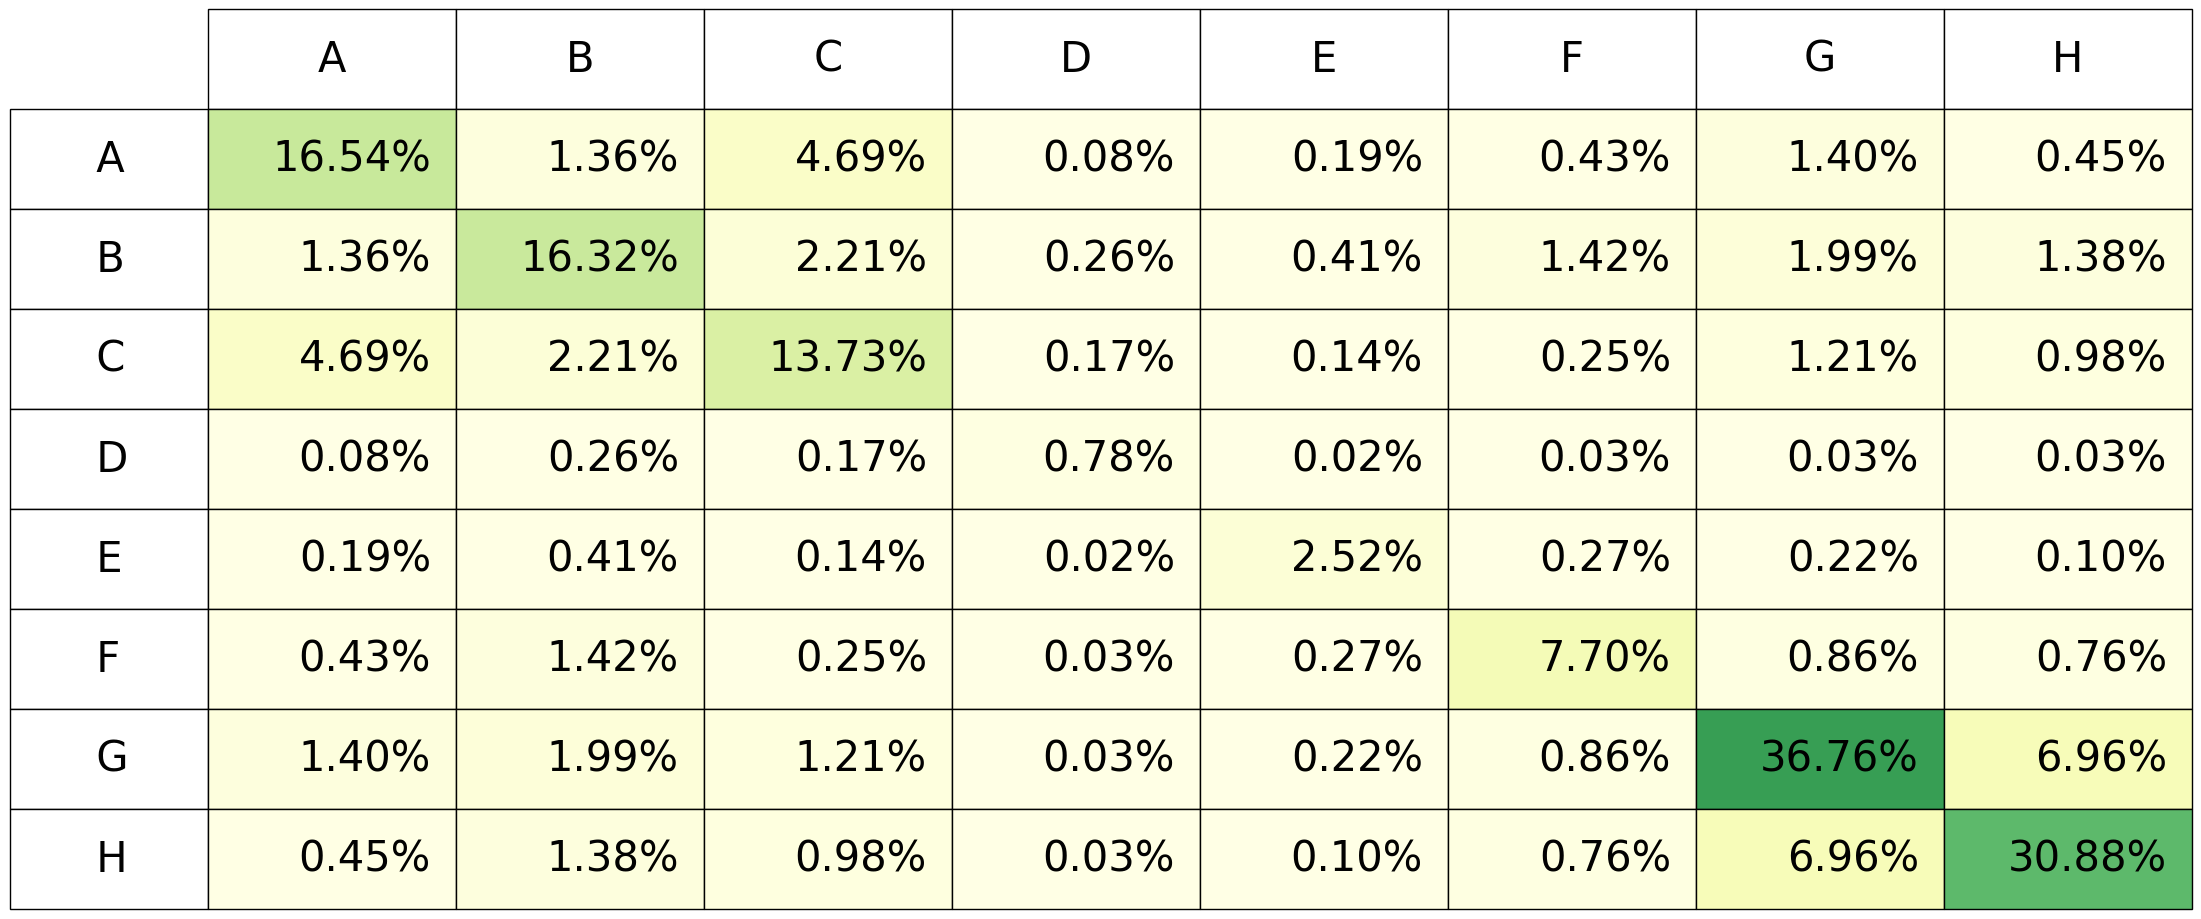

In [20]:
fig = plt.figure(figsize=(16,10), dpi=120)
#ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
vals = overlap_df.values
normal = mpl.colors.Normalize()
normal = mpl.colors.Normalize(vals.min()-1, vals.max()+vals.max()/2)
num_formatter = lambda x: "{:,d}".format(int(x))
percentage_formatter = lambda x: "{:.2%}".format(float(x)/doc_count)
index_formatter = lambda x: "     " + x + "     "

the_table=plt.table(cellText=np.vectorize(percentage_formatter)(vals), 
                    rowLabels=np.vectorize(index_formatter)(overlap_df.index), 
                    colLabels=overlap_df.columns, 
                    colWidths = [0.1]*(vals.shape[1]+3), loc='center',
                    cellColours=plt.cm.YlGn(normal(vals)))
the_table.set_fontsize(30)
the_table.scale(2, 6)
plt.axis("off")
plt.show()

## Class Distribution

In [49]:
i = 0
for classif in sorted(classifications_index.keys()):
    if len(classif) == 4:
        i+= 1
        print "{} : {:,d}, {:.5%}".format(classif, len(set(classifications_index[classif])), float(len(classifications_index[classif]))/doc_count)
print i

A-00 : 5, 0.00025%
A-01 : 47,218, 2.34945%
A-02 : 5, 0.00025%
A-03 : 5, 0.00025%
A-04 : 18, 0.00090%
A-05 : 9, 0.00045%
A-06 : 28, 0.00139%
A-07 : 20, 0.00100%
A-10 : 21, 0.00104%
A-11 : 10, 0.00050%
A-12 : 8, 0.00040%
A-13 : 2, 0.00010%
A-15 : 1, 0.00005%
A-16 : 67, 0.00333%
A-18 : 2, 0.00010%
A-21 : 1,222, 0.06080%
A-22 : 1,034, 0.05145%
A-23 : 6,144, 0.30571%
A-24 : 1,075, 0.05349%
A-25 : 2, 0.00010%
A-26 : 4, 0.00020%
A-27 : 6, 0.00030%
A-28 : 1, 0.00005%
A-29 : 1, 0.00005%
A-31 : 35, 0.00174%
A-32 : 1, 0.00005%
A-33 : 1, 0.00005%
A-34 : 1, 0.00005%
A-35 : 1, 0.00005%
A-36 : 4, 0.00020%
A-37 : 4, 0.00020%
A-38 : 1, 0.00005%
A-41 : 3,714, 0.18480%
A-42 : 898, 0.04468%
A-43 : 2,680, 0.13335%
A-44 : 2,316, 0.11524%
A-45 : 4,341, 0.21600%
A-46 : 1,762, 0.08767%
A-47 : 26,233, 1.30529%
A-48 : 3, 0.00015%
A-51 : 15, 0.00075%
A-52 : 3, 0.00015%
A-53 : 1, 0.00005%
A-54 : 1, 0.00005%
A-55 : 1, 0.00005%
A-56 : 1, 0.00005%
A-60 : 11, 0.00055%
A-61 : 182,351, 9.07332%
A-62 : 4,294, 0.21366%
A-

#### Classes with more than a set number of instances

### Number of classes/subclasses per section

In [53]:
i = 0
classes_numbers_dict = {}
subclasses_numbers_dict = {}
for sec in sections:
    classes_numbers_dict[sec] = 0
    subclasses_numbers_dict[sec] = 0
for classif in sorted(classifications_index.keys()):
    sect = classif[0]
    if len(classif) == 4:
        classes_numbers_dict[sect] += 1
    if len(classif) == 6:
        subclasses_numbers_dict[sect] += 1
        
for sec in sections:
    print "Section {} : Classes-> {:3,d}, Sections-> {:3,d}".format(sec, classes_numbers_dict[sec], subclasses_numbers_dict[sec])


Section A : Classes->  66, Sections-> 283
Section B : Classes->  70, Sections-> 406
Section C : Classes->  45, Sections-> 218
Section D : Classes->  26, Sections->  80
Section E : Classes->  35, Sections-> 100
Section F : Classes->  46, Sections-> 234
Section G : Classes->  56, Sections-> 297
Section H : Classes->  43, Sections-> 222


### Class/Subclass statistics with respect to sections

In [56]:
from collections import defaultdict

In [80]:
len(np.where(np.array(subclasses_numbers) < 3)[0])

113

In [82]:
i = 0
classes_dict = defaultdict(list)
subclasses_dict = defaultdict(list)
for classif in sorted(classifications_index.keys()):
    sect = classif[0]
    if len(classif) == 4:
        classes_dict[sect].append(classif)
    if len(classif) == 6:
        subclasses_dict[sect].append(classif)


for sec in sections:
    classes_numbers = []
    subclasses_numbers = []
    for cls in classes_dict[sec]:
        classes_numbers.append(len(classifications_index[cls]))
    for subcls in subclasses_dict[sec]:
        subclasses_numbers.append(len(classifications_index[subcls]))
    print """Section {} : 
        \tClass Mean: {}, Subclass Mean: {}, 
        \tClass Median: {}, Subclass Median: {}
        \tClass Min: {}, Subclass Min: {}
        \tClass Max: {}, Subclass Max: {}
        \tClass Stdev: {}, Subclass Stdev: {}
        \tClass < 3: {}, Subclass < 3: {}
        \tClass < 2: {}, Subclass < 2: {}""".format(sec, 
               np.mean(classes_numbers), np.mean(subclasses_numbers),
               np.median(classes_numbers), np.median(subclasses_numbers),
               np.min(classes_numbers), np.min(subclasses_numbers),
               np.max(classes_numbers), np.max(subclasses_numbers),
               np.std(classes_numbers), np.std(subclasses_numbers),
               len(np.where(np.array(classes_numbers) < 3)[0]), len(np.where(np.array(subclasses_numbers) < 3)[0]),
               len(np.where(np.array(classes_numbers) < 2)[0]), len(np.where(np.array(subclasses_numbers) < 2)[0]))

Section A : 
        	Class Mean: 4729.6969697, Subclass Mean: 1207.74204947, 
        	Class Median: 6.0, Subclass Median: 2.0
        	Class Min: 1, Subclass Min: 1
        	Class Max: 182351, Subclass Max: 77887
        	Class Stdev: 23193.6105732, Subclass Stdev: 6039.54811866
        	Class < 3: 24, Subclass < 3: 155
        	Class < 2: 17, Subclass < 2: 115
Section B : 
        	Class Mean: 4587.41428571, Subclass Mean: 832.327586207, 
        	Class Median: 415.0, Subclass Median: 3.0
        	Class Min: 1, Subclass Min: 1
        	Class Max: 47418, Subclass Max: 25181
        	Class Stdev: 9557.6531257, Subclass Stdev: 2638.20851919
        	Class < 3: 14, Subclass < 3: 188
        	Class < 2: 6, Subclass < 2: 137
Section C : 
        	Class Mean: 5372.86666667, Subclass Mean: 1279.7293578, 
        	Class Median: 7.0, Subclass Median: 5.0
        	Class Min: 1, Subclass Min: 1
        	Class Max: 85276, Subclass Max: 33496
        	Class Stdev: 14972.2210385, Subclass Stdev: 4

In [16]:
INVALID_CLASSIFICATION_LIMIT = 3
invalid_classes = set()
invalid_subclasses = set()
for clsf in classifications_index.keys():
    if len(classifications_index[clsf]) < INVALID_CLASSIFICATION_LIMIT:
        if clsf in classes:
            invalid_classes.add(clsf)
        if clsf in subclasses:
            invalid_subclasses.add(clsf)
valid_classes = list(set(classes) - invalid_classes)
valid_subclasses = list(set(subclasses) - invalid_subclasses)

In [20]:
for cls in valid_classes:
    print '{}-> {}'.format(cls, len(classifications_index[cls]))

C-25-> 3888
D-05-> 985
D-04-> 1966
D-07-> 79
D-06-> 3280
C-97-> 5
D-00-> 4
D-03-> 1263
D-02-> 1007
A-37-> 4
A-36-> 4
A-24-> 1075
A-26-> 4
A-27-> 6
A-21-> 1222
A-22-> 1034
A-23-> 6144
C-00-> 7
C-01-> 8262
C-02-> 5366
C-03-> 4637
C-04-> 4478
C-05-> 554
C-06-> 611
C-07-> 85276
C-08-> 33321
C-09-> 16124
H-61-> 7
G-66-> 20
H-16-> 3
G-16-> 19
G-15-> 5
G-12-> 307
H-10-> 72
H-11-> 15
H-03-> 51467
D-01-> 1787
B-61-> 2098
B-60-> 47418
B-63-> 5757
B-62-> 13992
B-65-> 38402
B-64-> 7306
B-67-> 3693
B-66-> 4403
B-69-> 5
B-68-> 398
A-31-> 35
C-13-> 231
C-12-> 49025
C-11-> 4447
C-10-> 6395
C-17-> 5
C-14-> 110
F-47-> 3
C-19-> 3
F-42-> 2524
F-41-> 6327
H-09-> 18
H-08-> 9
H-01-> 231566
H-00-> 48
G-20-> 15
G-21-> 4893
H-05-> 36408
H-04-> 264652
H-07-> 13
H-06-> 95
G-65-> 7
D-62-> 3
D-60-> 3
H-63-> 5
D-65-> 3
G-60-> 88
A-02-> 5
E-60-> 7
A-00-> 5
A-01-> 47218
A-06-> 28
A-07-> 20
A-04-> 18
A-05-> 9
B-14-> 12
B-16-> 11
A-81-> 11
B-10-> 13
G-30-> 5
B-12-> 9
G-32-> 3
G-62-> 6
E-63-> 3
C-22-> 4155
C-23-> 9979
C-

## Documents with more than one section/class/subclass

In [10]:
more_than_one_section = 0
more_than_one_class = 0
more_than_one_subclass = 0
for doc_id in doc_classification_map:
    doc_classifications = doc_classification_map[doc_id]
    section_classifications = [clsf for clsf in doc_classifications if len(clsf) == 1]
    if len(section_classifications) > 1:
        more_than_one_section += 1
    
    class_classifications = [clsf for clsf in doc_classifications if len(clsf) == 4]
    if len(class_classifications) > 1:
        more_than_one_class += 1
    
    subclass_classifications = [clsf for clsf in doc_classifications if len(clsf) == 6]
    if len(subclass_classifications) > 1:
        more_than_one_subclass += 1

In [12]:
print "More than one section: {}".format(more_than_one_section)
print "More than one class: {}".format(more_than_one_class)
print "More than one subclass: {}".format(more_than_one_subclass)

More than one section: 274738
More than one class: 376043
More than one subclass: 479380


## Plot loaded metrics

In [48]:
doc2vec_model_save_location

'/home/local/shalaby/parameter_search_doc2vec_models/sample_0.0001'

<IPython.core.display.Javascript object>


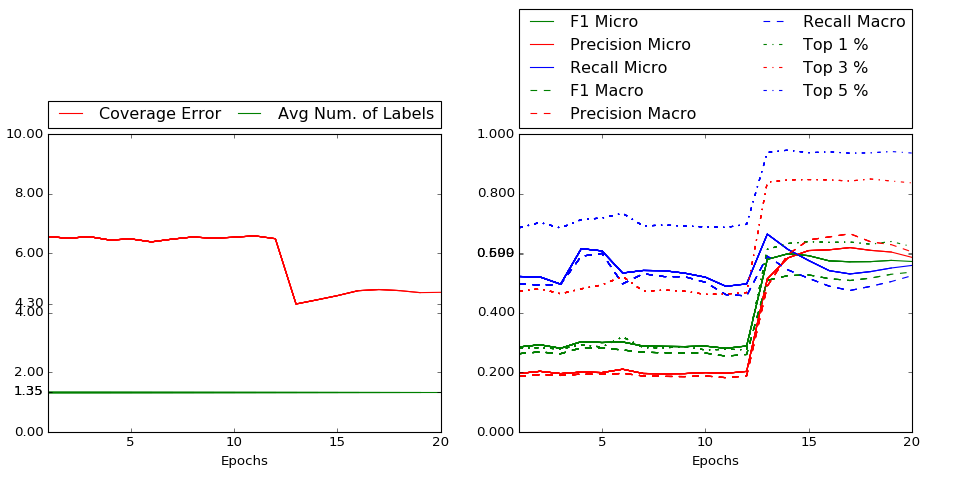

doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_{}_iter_1000_reg_0.001
Epoch 01: Coverage Error -> 6.56
Epoch 02: Coverage Error -> 6.51
Epoch 03: Coverage Error -> 6.56
Epoch 04: Coverage Error -> 6.45
Epoch 05: Coverage Error -> 6.49
Epoch 06: Coverage Error -> 6.39
Epoch 07: Coverage Error -> 6.48
Epoch 08: Coverage Error -> 6.55
Epoch 09: Coverage Error -> 6.51
Epoch 10: Coverage Error -> 6.54
Epoch 11: Coverage Error -> 6.59
Epoch 12: Coverage Error -> 6.50
Epoch 13: Coverage Error -> 4.30
Epoch 14: Coverage Error -> 4.44
Epoch 15: Coverage Error -> 4.58
Epoch 16: Coverage Error -> 4.75
Epoch 17: Coverage Error -> 4.79
Epoch 18: Coverage Error -> 4.75
Epoch 19: Coverage Error -> 4.68
Epoch 20: Coverage Error -> 4.69


In [32]:
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph()
print placeholder_model_name + "_" + GLOBAL_VARS.SVM_MODEL_NAME

for epoch in range(1,DOC2VEC_MAX_EPOCHS+1):
    try:
        model_name = placeholder_model_name.format(epoch)
        metrics = pickle.load(open(os.path.join(doc2vec_model_save_location, model_name, GLOBAL_VARS.SVM_MODEL_NAME, METRICS)))
        print "Epoch {:02d}: Coverage Error -> {:.2f}".format(epoch, metrics['coverage_error'])
        graph.add_metrics_to_graph(metrics, epoch)
    except IOError:
        break